In [373]:
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sci
from scipy import optimize
from netCDF4 import Dataset as netcdf
import xarray as xr

In [374]:
ds= pd.read_csv('/exports/csce/datastore/geos/groups/geos_EO/Databases/GRACE/outTest',names=['time','altimetry'],index_col='time')
G=ds.to_xarray()
G["old_time"]=G["time"]
G["time"]=pd.to_datetime(G["time"],unit='ms')
G.altimetry.attrs["units"]='m'

In [393]:
def tmsrdecomp(x,y0,dataset):
    #Fit Linear Trend
    p = np.polyfit(x, y0,1)
    dL = np.polyval(p,x)
#Fit Sinusoid
    y=y0-dL
    yu = max(y)
    yl = min(y)
    yr = (yu-yl)                              # Range of `y'
    yz = y-yu+(yr/2);

    zx=x[np.where(np.diff(np.sign(yz)))[0]]
#zx = x(yz .* circshift(yz,[0 1]) <= 0);  # Find zero-crossings
    per = 2*np.mean(np.diff(zx))                     # Estimate period
    ym = np.mean(y) 

    fit = lambda b,x : np.array(b[0])*np.array(np.sin(2*np.pi*x/b[1]+ 2*np.pi/b[2])) + b[3]
#fit = @(b,x)  b(1).*(sin(2*pi*x./b(2) + 2*pi/b(3))) + b(4);    % Function to fit

    fcn = lambda b : np.sum((fit(b,x)-y)**2)
#fcn = @(b) sum((fit(b,x) - y).^2);                              % Least-Squares cost function
    s= optimize.fmin(fcn , [yr, per,-1,ym])
#s = fminsearch(fcn, [yr;  per;  -1;  ym])                       % Minimise Least-Squares
    xp = np.linspace(min(x),max(x))
#xp = linspace(min(x),max(x));

    from scipy.interpolate import interp1d
    yp = fit(s,xp) 
    cc=interp1d(xp,fit(s,xp))(x)

    dataset.coords["xp"]= pd.to_datetime(xp,unit='s') #ms
    dataset["sinusoid"]=(("xp"),fit(s,xp))
    dataset["y"] = (("time"),y)
    dataset["y-cc"] = (("time"),y-cc)
    return dataset

In [394]:
def plot_tmsrdecomp(dataset,y0):
    fig, (ax1, ax2) = plt.subplots(2,figsize=(12,8), sharex=True)
    plt.suptitle(y0.name, fontsize=16)

    ax1.set_ylabel('m', fontsize=15)
    a,= ax1.plot(ds.time, y0, color='b',label = y0.name)
    b, = ax1.plot(ds.xp, ds.sinusoid, color='r', label = ds.sinusoid.name)
    ax1.axhline(y=0,linestyle='dashed',color='gray')
    p = [a,b]
    ax1.legend(p, [p_.get_label() for p_ in p])
    

    ax2.set_ylabel('m', fontsize=15)  
    ax2.plot(ds.time, y0, color='k')
    ax2.plot(ds.time, ds.y, color='r')
    ax2.plot(ds.time, ds["y-cc"], color='g')
    ax1.axhline(y=0,linestyle='dashed',color='gray')
    ax2.legend([y0.name, str(y0.name)+'-Linear Trend',str(y0.name)+"-Resample Sinusoid" ])
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [387]:
ds= tmsrdecomp(G.old_time,G.altimetry,G)
plot_tmsrdecomp(ds,ds.altimetry)


Optimization terminated successfully.
         Current function value: 550585.492688
         Iterations: 403
         Function evaluations: 761


<xarray.Dataset>
Dimensions:    (time: 121, xp: 50)
Coordinates:
  * time       (time) datetime64[ns] 2010-10-16T01:00:00 ... 2020-08-24T01:00:00
  * xp         (xp) datetime64[ns] 2010-10-16T01:00:00 ... 2020-08-24T01:00:00
Data variables:
    altimetry  (time) float64 0.0 40.28 84.9 ... -2.219e+03 -2.45e+03 -2.415e+03
    old_time   (time) int64 1287190800000 1289779200000 ... 1598230800000
    sinusoid   (xp) float64 -215.3 -84.61 166.0 181.3 ... 214.5 34.18 -194.5
    y          (time) float64 -181.1 -120.9 -56.25 58.2 ... -41.48 -252.7 -198.0
    y-cc       (time) float64 34.18 41.13 52.39 86.57 ... -33.73 -151.6 -3.425

In [395]:
a=pd.read_csv('/exports/csce/datastore/geos/groups/geos_EO/Databases/GRACE/time_series.dir/5_Svalbard/5_Svalbard_MERRA-2_smb_tseries.txt',header=1, sep="\s+",engine='python',names=["old_time","SMB","SMB_Corrected"],index_col="old_time")
SMB=a.to_xarray()
SMB.SMB.attrs["units"]= 'Gt'
SMB["second_time"]=total_seconds
SMB["time"]=pd.to_datetime(SMB["second_time"],unit='s')
SMB


<xarray.Dataset>
Dimensions:        (old_time: 182, second_time: 182, time: 182)
Coordinates:
  * old_time       (old_time) float64 2.002e+03 2.002e+03 ... 2.017e+03
  * second_time    (second_time) float64 1.022e+09 1.024e+09 ... 1.498e+09
  * time           (time) datetime64[ns] 2002-05-16T11:51:07.776000142 ... 2017-06-16T00:20:45.023996592
Data variables:
    SMB            (old_time) float64 95.82 92.14 76.21 ... -60.34 -58.38 -60.83
    SMB_Corrected  (old_time) float64 113.3 109.4 93.34 ... -75.82 -74.04 -76.67

In [396]:
ds= tmsrdecomp(SMB.second_time,SMB.SMB,SMB)
ds
#plot_tmsrdecomp(ds,ds.SMB)


Optimization terminated successfully.
         Current function value: 38306.781922
         Iterations: 221
         Function evaluations: 433


<xarray.Dataset>
Dimensions:        (old_time: 182, second_time: 182, time: 182, xp: 50)
Coordinates:
  * old_time       (old_time) float64 2.002e+03 2.002e+03 ... 2.017e+03
  * second_time    (second_time) float64 1.022e+09 1.024e+09 ... 1.498e+09
  * time           (time) datetime64[ns] 2002-05-16T11:51:07.776000142 ... 2017-06-16T00:20:45.023996592
  * xp             (xp) datetime64[ns] 2002-05-16T11:51:07.776000142 ... 2017-06-16T00:20:45.023996592
Data variables:
    SMB            (old_time) float64 95.82 92.14 76.21 ... -60.34 -58.38 -60.83
    SMB_Corrected  (old_time) float64 113.3 109.4 93.34 ... -75.82 -74.04 -76.67
    sinusoid       (xp) float64 -0.143 -3.976 1.57 3.412 ... -2.508 -2.703 3.479
    y              (time) float64 30.31 27.28 12.02 ... -8.222 -5.603 -7.389
    y-cc           (time) float64 30.45 28.47 14.24 ... -8.347 -7.403 -10.87

In [390]:
def deci2date(dataset):
    wholeyears = [int(value) for value in SMB.time.values]
    secondsperyear=[(datetime(wholeyear+1,1,1)-datetime(wholeyear, 1, 1)).days*24*60*60 for wholeyear in wholeyears]
    remainder =SMB.time.values-[int(value) for value in SMB.time.values]
    reminseconds = remainder*secondsperyear
    sinceepoch = [(datetime(wholeyear,1,1)-(datetime(1970,1,1))).days*24*60*60 for wholeyear in wholeyears]
    total_seconds = sinceepoch+reminseconds
    datetime = datetime(total_seconds,unit='s')
    return datetime

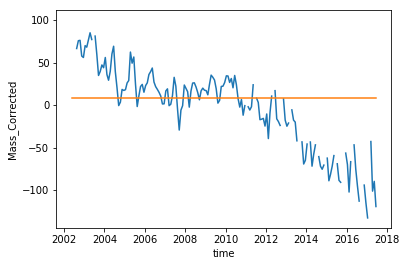

In [159]:
Mass.Mass.plot()
Mass.Mass_Corrected.plot()

In [ ]:
def multi_ELE_V(npng):
    fig, axes = plt.subplots(3,2,figsize=(18,12), sharex=True)
    
    for i in range(3):
        for j in range(2):
            
            ds= xr.open_dataset('/exports/csce/datastore/geos/groups/geos_EO/Databases/MAR/Svalbard-RA/Svalbard_Masked/Region_Tmsr/Svalbard_'+str(typ)+str((1*(i+1))+i+j)+'.nc')
            ds['time']= pd.date_range('2010-01-01','2020-12-31')
            SMB= ds.smb_mean
            
            m_data=io.loadmat('/geos/d14/CS2/dhdt/Timeseries/Svalbard_MR'+str((1*(i+1))+i+j)+'_MF/tmsr_45_90_07_rgi60_Svalbard__marine_R'+str((1*(i+1))+i+j)+'.mat')
            m_elevation = m_data['Tmsr'][0]
            t = m_data['time'][0]
            timepy= pd.to_datetime(t-719529, unit='D')
            m_ds = xr.Dataset(data_vars = dict(elev= (["t"],m_elevation+(0-m_elevation[0]))),coords=dict(t=timepy))

            matdata=io.loadmat('/geos/d14/CS2/dhdt/Timeseries/Svalbard_LR'+str((1*(i+1))+i+j)+'_MF/tmsr_45_90_07_rgi60_Svalbard_land_R'+str((1*(i+1))+i+j)+'.mat')
            elevation = matdata['Tmsr'][0]
            t = matdata['time'][0]
            timepy= pd.to_datetime(t-719529, unit='D')
            E_ds = xr.Dataset(data_vars = dict(elev= (["t"],elevation+(0-elevation[0]))),coords=dict(t=timepy))

            labels = ['Marine Terminating','Land Terminating ',]
            plt.rcParams['font.size'] = '14'
            color = 'tab:red'
            color2 = 'tab:cyan'
            
            axes[i,j].plot(m_ds.t, m_ds.elev, color=color)
            axes[i,j].legend(labels)
            axes[i, j].set_title('Region '+str((1*(i+1))+i+j))
            
            axes[i,j].plot(E_ds.t, E_ds.elev, color=color2)
            axes[i,j].plot(SMB.time.sel(time=slice('2010-07-16','2019-12-31')), SMB.sel(time=slice('2010-07-16','2019-12-31')).cumsum(), color=color2)
            axes[i,j].plot(G.time.sel(time=slice('2010-07-16','2019-12-31')), G.sel(time=slice('2010-07-16','2019-12-31')).cumsum(), color=color2)
            
            axes[i,j].axhline(y=0,linestyle='dashed',color='gray')
            axes[i,j].legend(labels)
            
    for ax in axes.flat:
        ax.set(xlabel='Time', ylabel='Elevation Change [m] recur')
    for ax in axes.flat:
        ax.label_outer()
    fig.suptitle('Svalbard Type Comparison')
    #fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig(npng)
    plt.show()